# &#x2699; Efficient random walks

## Bare-bone random walks

We have seen [earlier](rw) a simple implementation of random walks in Python.

In [1]:
import numpy as np


def naive_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """

    # The initial position is the origin
    position = np.zeros((N, M, dims))
    # Random walks
    for i in range(1, N):
        for w in range(M):
            dr = delta * np.random.choice([-1, 1], size=dims)
            position[i, w] = position[i - 1, w] + dr
    return position


To inspect the performance of the code, we can use the **profiler** included in jupyter notebooks. 

This is invoked via a so-called *magic* command `prun`, prepended in front of teh function. We also use the optional argument `-s cumulative` to sort the output in terms of the cumulative time spent in different parts of the code.

In [2]:
%prun -s cumulative naive_random_walker(100,1000)

         1881005 function calls in 7.033 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.033    7.033 {built-in method builtins.exec}
        1    0.000    0.000    7.033    7.033 <string>:1(<module>)
        1    1.108    1.108    7.033    7.033 2149943443.py:4(naive_random_walker)
    99000    1.784    0.000    5.925    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
   198000    0.356    0.000    4.141    0.000 <__array_function__ internals>:177(prod)
   198000    0.235    0.000    3.723    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   198000    0.410    0.000    3.488    0.000 fromnumeric.py:2955(prod)
   198000    0.926    0.000    3.078    0.000 fromnumeric.py:69(_wrapreduction)
   198000    1.449    0.000    1.449    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   198000    0.378    0.000    0.378    0.000 {built-in method 

The first three lines are not interesting as they refer to the function object itself.
The fourth item is immediately interesting as it refers to `method 'choice' of 'numpy.random.mtrand.RandomState'`. Clearly, the way we are generating the random steps is time-consuming, as we are picking from a Python list of two elements.

Such high-level calculations are typically  not performing well. We can therefore improve the performance of the code by considering an alternative way to generate lists of arrays such as `[-1,1,..]` in $d$ dimensions.

The simplest option is to use another function from `numpy` leveraging a paritcle to spin mapping that is common in physics.

Suppose that $n$ is a variable describing the occupation number of a site on a lattice, so that $n=0,1$. If we want to map empty sites to down spins and filled sites to up spins we can perform a chage of variable

$$s = 2n-1$$

so that $s=-1,1$ for $n=0,1$.

The same idea can be employed to our code, where we can replace the call of `np.random.choice` with `np.random.randint(0,2)*2-1`

In [3]:
def improved_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """

    # The initial position is the origin
    position = np.zeros((N, M, dims))
    # Random walks
    for i in range(1, N):
        for w in range(M):
            dr = delta * np.random.randint(0, 2, size=dims) * 2 - 1
            position[i, w] = position[i - 1, w] + dr
    return position


We can compare the two using the `%%time` magic command

In [4]:
%%time 
pos = naive_random_walker(100,1000)

CPU times: user 4.31 s, sys: 72.7 ms, total: 4.38 s
Wall time: 4.58 s


In [5]:
%%time 
pos = improved_random_walker(100,1000)

CPU times: user 3.9 s, sys: 98.2 ms, total: 3.99 s
Wall time: 6.13 s


The `naive` code is about 40% percent slower than the `improved` code.

Can we do better?

The code entails two `for` loops. In Python, for loops are slow and nested loops are particularly so.

The simplest way to accelerate the code is to leverage the strength of just in time compilers like [`numba`](https://numba.pydata.org). 

You can install `numba` via 

In [6]:
! pip install numba


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


`numba` accelerates the code through a clever translation of the Python code into `C/C++` code which is compiled on-the fly. This means that the first execution of the code can be slow (as pre-compilation occurs), but the second and following executions will benefit from the `C` translation.

For the translation to take place, `numba` needs to correctly infer the variable types used in the code. 

A black-box usage of numba is possible and is straighforward. It requires the addition of a **decorator** `@numba.njit` in fornt of the function that we want to accelerate.

In [7]:
import numba as nb


@nb.njit
def numba_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """

    # The initial position is the origin
    position = np.zeros((N, M, dims))
    # Random walks
    for i in range(1, N):
        for w in range(M):
            dr = delta * np.random.randint(0, 2, size=dims) * 2 - 1
            position[i, w] = position[i - 1, w] + dr
    return position


The first execution of the code is already very fast

In [8]:
%%time
walks = numba_random_walker(100,1000)

CPU times: user 1.74 s, sys: 276 ms, total: 2.01 s
Wall time: 2.05 s


the second execution is even faster

In [9]:
%%time
walks = numba_random_walker(100,1000)

CPU times: user 58.3 ms, sys: 2.35 ms, total: 60.6 ms
Wall time: 65.1 ms


How does this compare with Python's numerical library, `numpy`?

The random walk sampler can indeed be written in a single lines of code using `numpy`:

In [10]:
def numpy_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """
    return np.cumsum(
        delta * np.random.randint(0, 2, size=(N, M, dims)) * 2 - 1.0, axis=0
    )


We exploit the fact that `numpy` can perform cumulative sums rapidly over the array, and that one can specify the dimension along which to perform the sum with the parameter `axis`. In our case, the zeroth axis is the one that corresponds to time.

In [11]:
%%time
walks = numpy_random_walker(100,1000)

CPU times: user 3.65 ms, sys: 5.44 ms, total: 9.09 ms
Wall time: 14.5 ms


`numpy` provides an even faster solution, with a further speedup of a factor around 20, for a total speedup of about 1200 times with respect to the original naive code. 

In summary, we started with a naive Python code for a simulation of a d-dimensional random walk and accelerated it around 60 times with a few tweaks. But leveraging the vectorised operations of the numericla library provided an even larger benefit, allowign us to sample easily large numbers of walks.   

Notice, also, that all the different versions of the code store the entire statistics of walks throught time, which becomes memory intensive for large numbers of time steps, number of walks or high dimensions.

### Summary of the algorithms

Here below you can find the three main versions of the bare-bond random walk functions discussed above.

`````{tab-set}
````{tab-item} Naive Python 
```python
def naive_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """

    # The initial position is the origin
    position = np.zeros((N, M, dims))
    # Random walks
    for i in range(1, N):
        for w in range(M):
            dr = delta * np.random.choice([-1, 1], size=dims)
            position[i, w] = position[i - 1, w] + dr
    return position
```
````
````{tab-item} Numba
```python
@nb.njit
def numba_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """

    # The initial position is the origin
    position = np.zeros((N, M, dims))
    # Random walks
    for i in range(1, N):
        for w in range(M):
            dr = delta * np.random.randint(0, 2, size=dims) * 2 - 1
            position[i, w] = position[i - 1, w] + dr
    return position
```
````
````{tab-item} Numpy
```python
def numpy_random_walker(N, M, delta=1.0, dims=1):
    """
    Simulates a random walk. Parameters:
    - N: number of steps
    - M: number fo walkers
    - delta: size of one step (default=1)
    - dims : number of dimensions (default=1)
    """
    return np.cumsum(np.random.randint(0, 2, size=(N, M, dims)) * 2 - 1.0, axis=0)

```
````


`````

## Particle simulations and random walks

andom walks provide a mathematical and numerical framework to model a variety of problems, such as the movement of molecules in a liquid, fluctuations of stock prices, the path of an animal looking for food, and the spread of diseases in a population.

In this book we focus on liquids. It is pedagogical to explore how we can embed our knowledge of random walks in a framework for particle based simulations of liquids that we will use through the text.

We leverage the python model `atooms`. This provides a simplified interface to paritcle based simulations with various dynamics. Interestingly, it also allows us to provide arbritrary dynamics to simulate a given model. 

Here we test this idea in the case of random walks.


### Brief introduction to `atooms`

`atooms` is a high-level package to handle particle based simulations (see [full documentation](https://atooms.frama.io/atooms/tutorial/)).

`atooms` is object oriented: it contains objects with *attributes* and *methods* that allow us to access and modify the properties of the objects themselves and that also allow the objects to communicate with one another.


```{admonition} Key objects 
:class: key
- `System` contains the key information about our physical system. This includes:
    - the `particle` attribute, containing the degrees of freedom of al particles (e.g. positions and velocities)
    - the `cell` attribute, referring to the spatial domain of the simulation
    - physical properties of the system such as its `temperature` or `potential_energy`
- `Simulation` is a high-level class encapsulating the main workflow of a numerical calculation, such as collecting snapshots of the system at regular time.
- `Backend` a combined Python class containing references to the system and the specifications for its dynamical evolution.
```

To design a custom dynamics (such as a collection of Brownian particles) we want to comply with the following schematic structure:

```{mermaid}
%%{init: {'theme': 'forest'}}%%
flowchart LR
    Simulation --> CustomBackend --> System
```

We start from designing a custom `Backend`. This a custom class containing **at least** two essential in ingredients:

- a `system` attribute to refer t the state of our system
- a `run` method to prescribe a specific evolution (in this case, a random walk). It takes a single parameter `steps` referring to the number of steps we want to evolve the system for.

We can therefore create a custom backend that implements the ideas we developed above. In its simplest form, it involves two for loops: a first one over time and teh second one over the particles.

In [12]:
import numpy as np


class RandomWalkBackend(object):
    def __init__(self, system, delta=1.0):
        self.system = system
        self.delta = delta

    def run(self, steps):
        for i in range(steps):
            for p in self.system.particle:
                dr = self.delta * (np.random.randint(0, 2) * 2.0 - 1.0)
                p.position += dr


To use the backend, we first construct a system, then wrap the backedn around it and finally generate a simulation from the backend.

In [52]:
from atooms.system import System
from atooms.simulation import Simulation

N = 1000
L = 10
ndim = 3
#  set up N particles
system = System(N=N)
# assign the initial positions inside a cubic box of side L
for p in system.particle:
    p.position = np.random.uniform(0, L, size=ndim)

simulation = Simulation(RandomWalkBackend(system))
# run the simulation
simulation.run(100)


This minimal code performs the simulation, but we want to track some changes during the evolution. To do so, `atooms` employs the concept of `callbacks`: this are functions that are regularly called by the `Simulation` object to perform calculations on the `System`.

They are defined as standard python functions with a specific first argument `sim` that stands for the simulation object itself.

Let us write a callback to calculate the mean squared displacement:

In [58]:
def msd_callback(sim, initial_position, db):
    """ "
    Callback to compute the mean squared displacement.
    """
    msd = 0.0
    for i, p in enumerate(sim.system.particle):
        dr = p.position - initial_position[i]
        msd += np.sum(dr**2)
    msd /= len(sim.system.particle)
    db[sim.current_step] = msd


To use the callback, we need to **add** it to the simulation object. Remark that we make use of the method `dump` from `system` to retrieve the array of initial position quickly.

In [56]:
msd_db = {}
# interval to store the MSD
dt_msd = 10
simulation.add(msd_callback, dt_msd, initial_position=system.dump("pos"), db=msd_db)
simulation.run(1000)


In [57]:
import matplotlib.pyplot as plt

# convert dict to array
t, MSD = np.array(list(msd_db.keys())), np.array(list(msd_db.values()))
# subtract the starting time and plot
plt.loglog(t - t[0] + dt_msd, MSD)
plt.xlabel("t")
plt.ylabel("MSD")
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

### Accessing arrays of properties

The above backend (and callback) are slow. This is because the particle positions are accessed via for loops over the particles. `atooms` also allows for a vectorised access to these properties via two system methods:
- `dump(property)` which returns a copy of the property array.
- `view(property` which returns a view of the property array (i.e. a *pointer* to the same memory ).

We can use these to avoid some for looks and make the code more `numpy`-like and achieve a very significant speedup.

In [66]:
class RandomWalkBackendFast(object):
    def __init__(self, system, delta=1.0):
        self.system = system
        self.delta = delta

    def run(self, steps):
        position = self.system.view("pos")
        for k in range(steps):
            dr = np.random.uniform(-0.5, 0.5, size=position.shape)
            position += dr * self.delta


def msd_callback_fast(sim, initial_position, db):
    """ "
    Callback to compute the mean squared displacement.
    """
    msd = 0.0
    position = sim.system.view("pos")
    dr = position - initial_position
    msd += np.sum(dr**2)
    msd /= len(sim.system.particle)
    db[sim.current_step] = msd


system = System(N=N)
# assign the initial positions inside a cubic box of side L
positions = system.view("pos")
positions = np.random.uniform(0, L, size=system.view("pos").shape)

simulation = Simulation(RandomWalkBackendFast(system))

msd_db = {}
dt_msd = 10
simulation.add(
    msd_callback_fast, dt_msd, initial_position=system.dump("pos"), db=msd_db
)
simulation.run(1000)


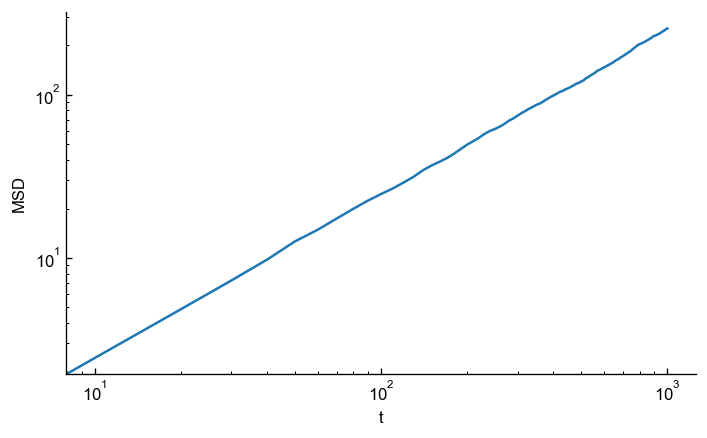

In [67]:
t, MSD = np.array(list(msd_db.keys())), np.array(list(msd_db.values()))
# subtract the starting time and plot
plt.loglog(t, MSD)
plt.xlabel("t")
plt.ylabel("MSD")
plt.show()
